In [1]:
## PRELIMINARIES ##
# general 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
import random as rn
import csv
import pickle

# for data
from parflow import Run
from parflow.tools.io import read_pfb, read_clm
from parflow.tools.fs import mkdir
from parflow.tools.settings import set_working_directory
import subsettools.subsettools as st
import hf_hydrodata as hf
from hf_hydrodata import gridded 
import hf_hydrodata.point

# for lstm
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable 

## NASH-SUTCLIFFE EFFICIENCY ##
def nse(actual, predictions):
    return (1-(np.sum((actual-predictions)**2)/np.sum((actual-np.mean(actual))**2)))

#plt.rcParams.update({'font.size': 20})

## finding sites, getting data, etc

In [7]:
## COLLECT DATA FOR SINGLE COLUMN (Beartown) ##
site_id = '327:CO:SNTL'
start_date = '1979-10-01'
end_date = '2022-09-30'

# SWE [mm]
site_df_swe = hf.point.get_point_data(dataset='snotel', variable='swe', temporal_resolution='daily', aggregation='sod', 
                                             date_start=start_date, date_end=end_date,site_ids=[site_id])

# precipitation [mm]
site_df_precip = hf.point.get_point_data(dataset='snotel', variable='precipitation', temporal_resolution='daily', aggregation='sum', 
                                   date_start=start_date, date_end=end_date,site_ids=[site_id])

# temperature [C]
site_df_temp = hf.point.get_point_data(dataset='snotel', variable='air_temp', temporal_resolution='daily', aggregation='mean', 
                                 date_start=start_date, date_end=end_date,site_ids=[site_id])

metadata_df = hf.point.get_point_metadata(dataset='snotel', variable='swe', temporal_resolution='daily', aggregation='sod', 
                                             date_start=start_date, date_end=end_date,site_ids=[site_id])

collecting data...
data collected.
collecting data...
data collected.
collecting data...
data collected.


In [10]:
## GET CW3E DATA ##
forcing_dir = '/home/mcburns/single_column_model/single_column_beartown'
met_data = pd.read_csv(os.path.join(forcing_dir, 'cw3e_forcing_bc/forcing1D_daily.txt'),sep=' ',header=None, index_col=False)
# units: DSWR [W/m2], DLWR [W/m2], APCP [mm/s], Temp [K], UGRD [m/s], VGRD [m/s], Press [pa], SPFH [kg/kg]
met_data.columns = ["DSWR","DLWR","precip","temp","wind (E)","wind (N)","pressure","q"]
#met_data.rename(columns={"0": "DSWR", "1": "DLWR", "2": "precip", "3": "temp", "4": "wind (E)", "5": "wind (N)", "6": "pressure", "7": "q"})

In [11]:
## PROCESSING ##
# get each dataset by itself, deal with nan values, scale to [0,1] or [-1,1] depending on the values of the dataset

# make data all start at the same point
precip = site_df_precip.set_axis(['date','precip'], axis='columns')
precip_start = precip['date'][0]
temp = site_df_temp.set_axis(['date','temp'], axis='columns')
temp_start = temp['date'][0]
tot_swe = site_df_swe.set_axis(['date','swe'], axis='columns')
swe_start = tot_swe['date'][0]

date = max([pd.to_datetime(temp_start),pd.to_datetime(precip_start)])
if date.month < 10:
    data_start = str(date.year)+'-10-01'
else:
    data_start = str(date.year+1)+'-10-01'

# precip: fill nan values with zero
precip_start = precip.loc[precip['date'] == data_start].index[0]
precip = precip[precip_start:].reset_index().drop(columns='index')
precip['year'] = pd.DatetimeIndex(precip['date']).year
precip = precip.set_index('date')
precip['precip'] = precip['precip'].fillna(0)
precip['precip'] = MaxAbsScaler().fit_transform(precip[['precip']])

# temp: fill nan values with linear interpolation
temp_start = temp.loc[temp['date'] == data_start].index[0]
temp = temp[temp_start:].reset_index().drop(columns='index')
temp = temp.set_index('date')
temp['temp'] = temp['temp'].interpolate()
temp['temp'] = MaxAbsScaler().fit_transform(temp[['temp']])

# swe: fill nan values with linear interpolation
swe_start = tot_swe.loc[tot_swe['date'] == data_start].index[0]
tot_swe = tot_swe[swe_start:].reset_index().drop(columns='index')
tot_swe['year'] = pd.DatetimeIndex(tot_swe['date']).year
tot_swe = tot_swe.set_index('date')
tot_swe['swe'] = tot_swe['swe'].interpolate()

# count years
years = np.unique(tot_swe['year'])
years = years[~np.isnan(years)]
num_values = len(years)

# define scaling object for swe so data can be inverted later
# MinMax so that the values don't go below 0
scaler_swe = MinMaxScaler()
tot_swe['swe'] = scaler_swe.fit_transform(tot_swe[['swe']])

# combine all datasets and add SNOTEL metadata characteristitcs
tot_non_swe = precip.join(temp)
tot_non_swe['elevation'] = metadata_df['usda_elevation'][0]
tot_non_swe['elevation'] = MaxAbsScaler().fit_transform(tot_non_swe[['elevation']])
tot_non_swe['latitude'] = metadata_df['latitude'][0]
tot_non_swe['latitude'] = MaxAbsScaler().fit_transform(tot_non_swe[['latitude']])
tot_non_swe['longitude'] = metadata_df['longitude'][0]
tot_non_swe['longitude'] = MaxAbsScaler().fit_transform(tot_non_swe[['longitude']])

# add CW3E forcing characteristics - transform before putting in array
# shortwave radiation, longwave radiation, wind (E and N), pressure, specific humidity
tot_non_swe['DSWR'] = MaxAbsScaler().fit_transform(met_data['DSWR'].to_numpy().reshape(-1,1))
tot_non_swe['DLWR'] = MaxAbsScaler().fit_transform(met_data['DLWR'].to_numpy().reshape(-1,1))
tot_non_swe['wind (E)'] = MaxAbsScaler().fit_transform(met_data['wind (E)'].to_numpy().reshape(-1,1))
tot_non_swe['wind (N)'] = MaxAbsScaler().fit_transform(met_data['wind (N)'].to_numpy().reshape(-1,1))
tot_non_swe['pressure'] = MaxAbsScaler().fit_transform(met_data['pressure'].to_numpy().reshape(-1,1))
tot_non_swe['q'] = MaxAbsScaler().fit_transform(met_data['q'].to_numpy().reshape(-1,1))

# change years to water years - assume dates of swe/non swe are the same
leap=[]
for i in range(0,len(tot_swe)-1):
    d_non_swe = pd.to_datetime(tot_non_swe.index[i])
    d_swe = pd.to_datetime(tot_swe.index[i])
    if(d_non_swe.month >= 10):
        tot_non_swe.loc[tot_non_swe.index[i],'year'] += 1
    if(d_swe.month >= 10):
        tot_swe.loc[tot_swe.index[i],'year'] += 1
    if((d_non_swe.month==2) and (d_non_swe.day==29)):
        leap.append(tot_swe.index[i])
        
# get rid of leap days
tot_swe = tot_swe.drop(leap, axis=0)
tot_non_swe = tot_non_swe.drop(leap, axis=0)

with open("sc_normalize.pkl" , 'wb') as file:  
    pickle.dump(scaler_swe, file)

In [12]:
# get nice 3D array - swe and non swe are now the same length of time
l_swe = []
l_non_swe = []
new_years = []
for i in range(0,num_values):
    yr = years[i]
    df_swe = tot_swe.loc[tot_swe['year'] == yr]
    temp_swe = df_swe.loc[:, df_swe.columns != 'year'].to_numpy()
    df_non_swe = tot_non_swe.loc[tot_non_swe['year'] == yr]
    temp_non_swe = df_non_swe.loc[:, df_non_swe.columns != 'year'].to_numpy()
    
    # get rid of years without 365 days of data
    # consider making a more nuanced way to filter data
    if((temp_swe.size == (365*temp_swe.shape[1])) and (temp_non_swe.size == (365*temp_non_swe.shape[1]))):
        l_swe.append(temp_swe)
        l_non_swe.append(temp_non_swe)
        new_years.append(yr)
    
# create arrays with all years
full_swe = np.stack(l_swe).astype(np.float32)
full_non_swe = np.stack(l_non_swe).astype(np.float32)
years = np.stack(new_years).astype(np.int_)
num_values = len(years)

In [13]:
# get peak SWE values for each year & bin them
peak_values = np.column_stack((years, np.zeros(num_values)))
for i in range(0,num_values):
    yr = years[i]
    df_swe = tot_swe.loc[tot_swe['year'] == yr]
    peak_values[i,1] = max(df_swe['swe'])
peak_values = pd.DataFrame(peak_values, columns = ['year','peak swe'])
peak_values['bins'] = pd.qcut(peak_values['peak swe'], q=3, labels=['below avg', 'avg', 'above avg'])

# select training data (make sure both are divisible by 3)
num_train_yrs = 24
num_test_yrs = 6
training_years = np.zeros(num_train_yrs)

# set seed for reproducibility, randomly select years
# 42 for initial set of years
total_sample_size = int(num_train_yrs/3)+int(num_test_yrs/3)
rn.seed(8)
abv_avg_i = rn.sample(peak_values.loc[peak_values['bins'] == 'above avg'].index.to_list(), total_sample_size)
avg_i = rn.sample(peak_values.loc[peak_values['bins'] == 'avg'].index.to_list(), total_sample_size)
bel_avg_i = rn.sample(peak_values.loc[peak_values['bins'] == 'below avg'].index.to_list(), total_sample_size)

# fill training set
for i in range(0,int(num_train_yrs/3)):
    training_years[0+i] = years[abv_avg_i[i]]
    training_years[8+i] = years[avg_i[i]]
    training_years[16+i] = years[bel_avg_i[i]]

# use the remaining years as testing years
testing_years = np.array([years[abv_avg_i[total_sample_size-1]], years[avg_i[total_sample_size-1]], years[bel_avg_i[total_sample_size-1]],
                          years[abv_avg_i[total_sample_size-2]], years[avg_i[total_sample_size-2]], years[bel_avg_i[total_sample_size-2]]])

In [14]:
# consolidate training set
train_swe = []
train_non_swe = []
for i in range(0,num_train_yrs):
    yr = training_years[i]
    df_swe = tot_swe.loc[tot_swe['year'] == yr]
    temp_swe = df_swe.loc[:, df_swe.columns != 'year'].to_numpy()
    df_non_swe = tot_non_swe.loc[tot_non_swe['year'] == yr]
    temp_non_swe = df_non_swe.loc[:, df_non_swe.columns != 'year'].to_numpy()
    
    train_swe.append(temp_swe)
    train_non_swe.append(temp_non_swe)

# consolidate testing set
test_swe = []
test_non_swe = []
for i in range(0,num_test_yrs):
    yr = testing_years[i]
    df_swe = tot_swe.loc[tot_swe['year'] == yr]
    temp_swe = df_swe.loc[:, df_swe.columns != 'year'].to_numpy()
    df_non_swe = tot_non_swe.loc[tot_non_swe['year'] == yr]
    temp_non_swe = df_non_swe.loc[:, df_non_swe.columns != 'year'].to_numpy()
    
    test_swe.append(temp_swe)
    test_non_swe.append(temp_non_swe)
    
# create arrays with all years
train_swe = np.stack(train_swe).astype(np.float32)
train_non_swe = np.stack(train_non_swe).astype(np.float32)
test_swe = np.stack(test_swe).astype(np.float32)
test_non_swe = np.stack(test_non_swe).astype(np.float32)

In [15]:
## FORMAT TRAINING DATA ##
# format as pytorch tensors
train_swe_tensors = torch.from_numpy(train_swe)
train_non_swe_tensors = torch.from_numpy(train_non_swe)

test_swe_tensors = torch.from_numpy(test_swe)
test_non_swe_tensors = torch.from_numpy(test_non_swe)

# reshape to 3D inputs
# if num_yrs == 1: 
#     train_non_swe_tensors = torch.reshape(train_non_swe_tensors, (train_non_swe_tensors.shape[0], train_non_swe_tensors.shape[1]))
#     test_non_swe_tensors = torch.reshape(test_non_swe_tensors, (test_non_swe_tensors.shape[0], test_non_swe_tensors.shape[1]))

#train_swe_tensors = torch.reshape(train_swe_tensors, (train_swe_tensors.shape[0], 1, train_swe_tensors.shape[1]))
#test_swe_tensors = torch.reshape(test_swe_tensors, (test_swe_tensors.shape[0], 1, test_swe_tensors.shape[1]))

## start consolidating model things

In [10]:
# decrease randomness
# research this more thoroughly!
# https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(42)

In [2]:
# MODEL MODEL MODEL
# should i include this? look into it a bit more
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# model definition
# from https://cnvrg.io/pytorch-lstm/ 
class LSTM(nn.Module):
    def __init__(self, input_size, batch_size, output_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size           # input size
        self.batch_size = batch_size           # batch size
        self.output_size = output_size         # output_size 
        self.num_layers = num_layers           # number of recurrent layers of LSTM
        self.hidden_size = hidden_size         # number of features in hidden state
        #self.seq_length = seq_length           # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=0.4)
        #self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        #self.fc = nn.Linear(128, num_classes) #fully connected last layer
        
        self.fc = nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.randn(self.num_layers, self.batch_size, self.hidden_size)  # hidden state
        c_0 = torch.randn(self.num_layers, self.batch_size, self.hidden_size)  # internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #print(output.shape)
        out = self.relu(output) # experimental relu layer???
        out = self.fc(out)
        #print(output.shape)
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        #out = self.relu(hn)
        #out = self.fc_1(out) #first Dense
        #out = self.fc(out) #Final Output
        return out.view(-1)

In [12]:
# parameters
num_epochs = 2500
learning_rate = 0.00001

input_size = 11         # number of features in input
batch_size = 1          # batch size
output_size = 1         # number of output features (just SWE) 
hidden_size = 256      # number of features in hidden state
num_layers = 2          # number of stacked lstm layers

# instantiate model
lstm = LSTM(input_size, batch_size, output_size, hidden_size, num_layers)
#lstm.to(DEVICE)

In [13]:
# train the model 
# define loss function and optimizers
loss_fn = torch.nn.SmoothL1Loss()                                 # loss function
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # optimizer and solver: Adam

# train model - doesn't work for 1 yr of data
loss_record = np.zeros(num_epochs)
val_record = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # training
    for i in range(num_train_yrs):
        # reshape to be in format (sequence_length, batch_size, input_size)
        x_train = torch.reshape(train_non_swe_tensors[i], (train_non_swe_tensors[i].shape[0], 1, train_non_swe_tensors[i].shape[1]))
        y_train = train_swe_tensors[i]
        #torch.reshape(train_swe_tensors[i], (1, train_swe_tensors[i].shape[0], train_swe_tensors[i].shape[1]))

        outputs = lstm.forward(x_train) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = loss_fn(outputs.reshape(outputs.shape[0],1), y_train)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop

    # validation
    with torch.no_grad():
        for i in range(num_test_yrs):
            # reshape to be in format (sequence_length, batch_size, input_size)
            x_test = torch.reshape(test_non_swe_tensors[i], (test_non_swe_tensors[i].shape[0], 1, test_non_swe_tensors[i].shape[1]))
            y_test = test_swe_tensors[i]
    
            output_val = lstm.forward(x_test) #forward pass
    
            # obtain the loss function
            loss_val = loss_fn(outputs.reshape(output_val.shape[0],1), y_test)
   
    loss_record[epoch] = loss.item()
    val_record[epoch] = loss_val.item()

    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
        print("Epoch: %d, loss: %1.5f" % (epoch, loss_val.item())) 

# save model 
torch.save(lstm, 'sc_beartown_lstm.pt')

Epoch: 0, loss: 0.01219
Epoch: 0, loss: 0.01203
Epoch: 100, loss: 0.00249
Epoch: 100, loss: 0.00487
Epoch: 200, loss: 0.00262
Epoch: 200, loss: 0.00428
Epoch: 300, loss: 0.00345
Epoch: 300, loss: 0.00514
Epoch: 400, loss: 0.00285
Epoch: 400, loss: 0.00463
Epoch: 500, loss: 0.00232
Epoch: 500, loss: 0.00429
Epoch: 600, loss: 0.00205
Epoch: 600, loss: 0.00444
Epoch: 700, loss: 0.00192
Epoch: 700, loss: 0.00433
Epoch: 800, loss: 0.00182
Epoch: 800, loss: 0.00450
Epoch: 900, loss: 0.00182
Epoch: 900, loss: 0.00444
Epoch: 1000, loss: 0.00154
Epoch: 1000, loss: 0.00455
Epoch: 1100, loss: 0.00152
Epoch: 1100, loss: 0.00425
Epoch: 1200, loss: 0.00136
Epoch: 1200, loss: 0.00386
Epoch: 1300, loss: 0.00137
Epoch: 1300, loss: 0.00440
Epoch: 1400, loss: 0.00158
Epoch: 1400, loss: 0.00476
Epoch: 1500, loss: 0.00105
Epoch: 1500, loss: 0.00438
Epoch: 1600, loss: 0.00069
Epoch: 1600, loss: 0.00421
Epoch: 1700, loss: 0.00093
Epoch: 1700, loss: 0.00435
Epoch: 1800, loss: 0.00171
Epoch: 1800, loss: 0.0048

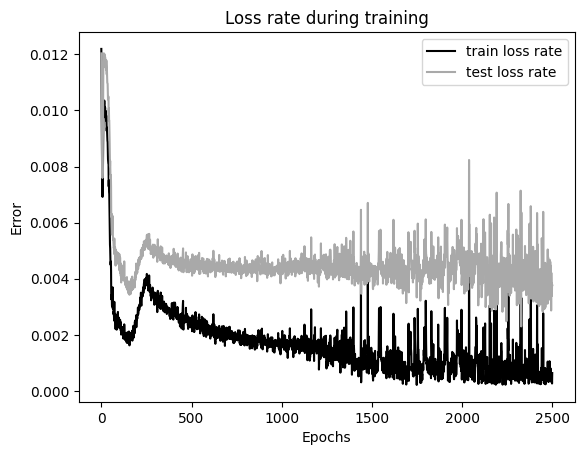

In [15]:
# plot loss record - TRAINING
plt.plot(loss_record, c='black',label='train loss rate')
plt.plot(val_record, c='darkgray',label='test loss rate')
plt.title('Loss rate during training')
#plt.title(f'learning rate: {learning_rate:.5f}')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

## evaluate

In [6]:
# load model
lstm = torch.load('/home/mcburns/single_column_model/single_column_beartown/sc_beartown_lstm.pt', map_location=torch.device("cpu"))
with open('/home/mcburns/single_column_model/single_column_beartown/sc_normalize.pkl', 'rb') as file:  
    scaler_swe = pickle.load(file)

RMSE: 57.05
normal RMSE: 0.10
NSE: 0.91
R2: 0.91
Spearman's rho: 0.94
delta peak SWE: -45.47
normal delta peak SWE: 0.14
delta days: 5.83


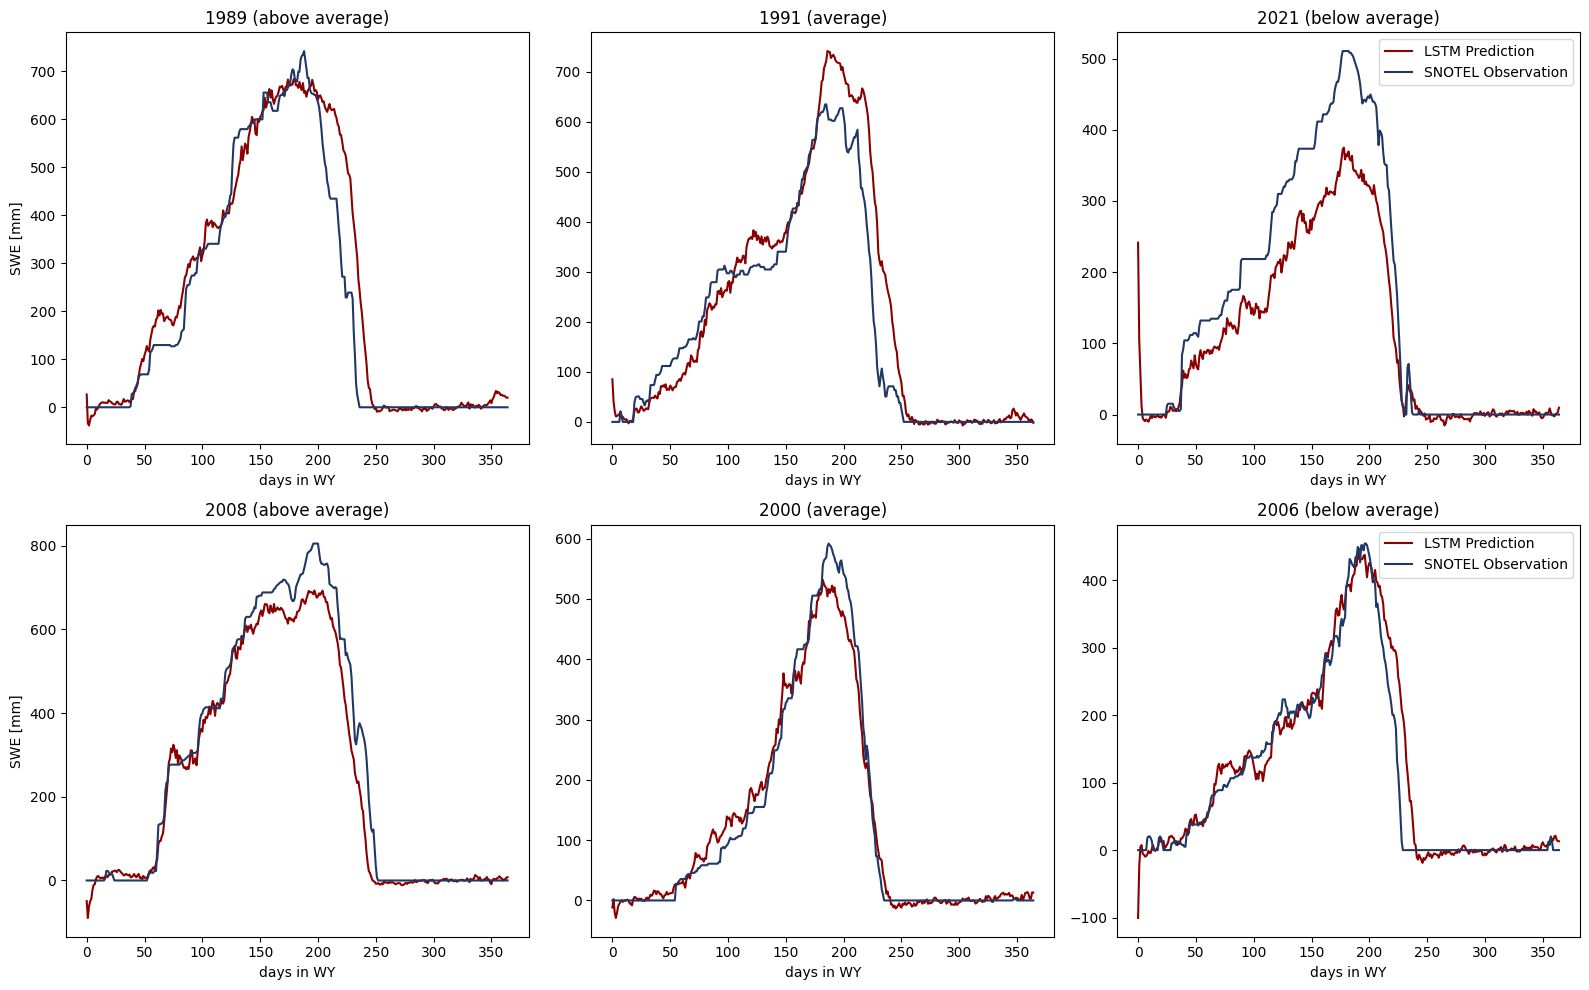

In [21]:
## TESTING DATA ##
# blue is actual, red is predicted
plt.figure(figsize=(16,10))
statistics = pd.DataFrame(columns=['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'delta days'])
for y in range(num_test_yrs):
    wy = testing_years[y]

    test_swe_tensors = torch.from_numpy(test_swe[y])
    test_non_swe_tensors = torch.from_numpy(test_non_swe[y])

    # predict 
    swe_pred = lstm(torch.reshape(test_non_swe_tensors, (test_non_swe_tensors.shape[0], 1, test_non_swe_tensors.shape[1])))

    # inverse transform to produce swe values
    swe_pred = scaler_swe.inverse_transform(swe_pred.detach().numpy().reshape(-1,1))
    swe_actual = scaler_swe.inverse_transform(test_swe_tensors.detach().numpy())

    # peak swe
    peak_lstm = max(swe_pred)[0]
    peak_obs = max(swe_actual)[0]
    peak = (peak_lstm + peak_obs)/2

    # calculate RMSE
    mse = mean_squared_error(swe_actual, swe_pred)
    rmse = np.sqrt(mse)

    # calculate NSE
    nash_sut = nse(swe_actual, swe_pred)

    # calculate r2
    r_2 = r2_score(swe_actual, swe_pred)

    # calculate Spearman's rho
    spearman_rho = stats.spearmanr(swe_actual, swe_pred)[0]

    # calculate delta peak SWE
    delta_peak = peak_lstm - peak_obs

    # calculate first snow free day
    # obs/clm: swe == 0
    # pred: swe < 0
    arr_lstm = np.where(swe_pred < 0)[0]
    arr_obs = np.where(swe_actual == 0)[0]
    melt_lstm = np.where(arr_lstm > 100)[0]
    melt_obs = np.where(arr_obs > 100)[0]
    try:
        delta_days = arr_lstm[melt_lstm[0]] - arr_obs[melt_obs[0]]
    except:
        delta_days = 365 - arr_obs[melt_obs[0]]

    statistics.loc[len(statistics)] = [rmse, rmse / peak, nash_sut, r_2, spearman_rho, delta_peak, delta_peak/peak, delta_days]

    #print(swe_pred)
    plt.subplot(2, 3, y+1)
    plt.plot(swe_pred, label='LSTM Prediction', c='darkred')
    plt.plot(swe_actual, label='SNOTEL Observation', c='#203864')
    if (y%3) == 1:
        plt.title(f'{testing_years[y]:.0f} (average)') 
    if (y%3) == 2:
        plt.title(f'{testing_years[y]:.0f} (below average)')
        plt.legend()
    if (y%3) == 0:
        plt.title(f'{testing_years[y]:.0f} (above average)') 
        plt.ylabel('SWE [mm]')
    #plt.title(f'{testing_years[y]:.0f}: RMSE: {rmse:.2f} ') 
    plt.xlabel('days in WY')

    # save the output files
    swe_pred = pd.DataFrame(swe_pred)
    swe_actual = pd.DataFrame(swe_actual)
    #swe_pred.to_csv(os.path.join('single_column_files/', str(wy)+'_swe_pred.txt'),sep=' ',header=None, index=False, index_label=False)
    #swe_actual.to_csv(os.path.join('single_column_files/', str(wy)+'_swe_actual.txt'),sep=' ',header=None, index=False, index_label=False)
    
plt.tight_layout()

print(f"RMSE: {np.mean(statistics['rmse']):.2f}")
print(f"normal RMSE: {np.mean(statistics['normal rmse']):.2f}")
print(f"NSE: {np.mean(statistics['nse']):.2f}")
print(f"R2: {np.mean(statistics['r2']):.2f}")
print(f"Spearman's rho: {np.mean(statistics['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.mean(statistics['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.mean(np.abs(statistics['normal delta peak'])):.2f}")
print(f"delta peak SWE: {np.mean(statistics['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.mean(np.abs(statistics['normal delta peak'])):.2f}")
print(f"delta days: {np.mean(statistics['delta days']):.2f}")

statistics.to_csv('sc_beartown_statistics.txt',sep=' ',header=None, index=False, index_label=False)

In [35]:
# evaluate on snotel data from another site

def get_snotel(site_id, start_date, end_date, name):
    # GET DATA
    site_df_swe = hf.point.get_point_data(dataset='snotel', variable='swe', temporal_resolution='daily', aggregation='sod', 
                                             date_start=start_date, date_end=end_date,site_ids=[site_id])
    site_df_precip = hf.point.get_point_data(dataset='snotel', variable='precipitation', temporal_resolution='daily', aggregation='sum', 
                                   date_start=start_date, date_end=end_date,site_ids=[site_id])
    site_df_temp = hf.point.get_point_data(dataset='snotel', variable='air_temp', temporal_resolution='daily', aggregation='mean', 
                                 date_start=start_date, date_end=end_date,site_ids=[site_id])
    metadata_df = hf.point.get_point_metadata(dataset='snotel', variable='swe', temporal_resolution='daily', aggregation='sod', 
                                             date_start=start_date, date_end=end_date,site_ids=[site_id])
    
    # FOR NIWOT
    met_data = pd.read_csv(os.path.join('single_column_'+name+'/', 'forcing1D.txt'),sep=' ',header=None, index_col=False)
    met_data.columns = ["DSWR","DLWR","precip","temp","wind (E)","wind (N)","pressure","q"]
    
    # PROCESS
    precip = site_df_precip.set_axis(['date','precip'], axis='columns')
    # precip_start = precip['date'][0]
    temp = site_df_temp.set_axis(['date','temp'], axis='columns')
    # temp_start = temp['date'][0]
    tot_swe = site_df_swe.set_axis(['date','swe'], axis='columns')
    # swe_start = tot_swe['date'][0]
    
    # list = [pd.to_datetime(temp_start),pd.to_datetime(precip_start)]
    # data_start = max(list).strftime("%Y-%m-%d")

    # precip: fill nan values with zero
    #precip_start = precip.loc[precip['date'] == date_start].index[0]
    #precip = precip[precip_start:].reset_index().drop(columns='index')
    precip['year'] = pd.DatetimeIndex(precip['date']).year
    precip = precip.set_index('date')
    precip['precip'] = precip['precip'].fillna(0)
    precip['precip'] = MaxAbsScaler().fit_transform(precip[['precip']])
    
    # temp: fill nan values with linear interpolation
    #temp_start = temp.loc[temp['date'] == date_start].index[0]
    #temp = temp[temp_start:].reset_index().drop(columns='index')
    temp = temp.set_index('date')
    temp['temp'] = temp['temp'].interpolate()
    temp['temp'] = MaxAbsScaler().fit_transform(temp[['temp']])
    
    # swe: fill nan values with linear interpolation
    #swe_start = tot_swe.loc[tot_swe['date'] == date_start].index[0]
    #tot_swe = tot_swe[swe_start:].reset_index().drop(columns='index')
    tot_swe['year'] = pd.DatetimeIndex(tot_swe['date']).year
    tot_swe = tot_swe.set_index('date')
    tot_swe['swe'] = tot_swe['swe'].interpolate()
    
    # count years
    years = np.unique(tot_swe['year'])
    years = years[~np.isnan(years)]
    num_values = len(years)
    
    # define scaling object for swe so data can be inverted later
    scaler_swe = MaxAbsScaler()
    tot_swe['swe'] = scaler_swe.fit_transform(tot_swe[['swe']])
    
    # combine all datasets and add SNOTEL metadata characteristitcs
    tot_non_swe = precip.join(temp)
    tot_non_swe['elevation'] = metadata_df['usda_elevation'][0]
    tot_non_swe['elevation'] = MaxAbsScaler().fit_transform(tot_non_swe[['elevation']])
    tot_non_swe['latitude'] = metadata_df['latitude'][0]
    tot_non_swe['latitude'] = MaxAbsScaler().fit_transform(tot_non_swe[['latitude']])
    tot_non_swe['longitude'] = metadata_df['longitude'][0]
    tot_non_swe['longitude'] = MaxAbsScaler().fit_transform(tot_non_swe[['longitude']])

    # add CW3E forcing characteristics - transform before putting in array
    # shortwave radiation, longwave radiation, wind (E and N), pressure, specific humidity
    tot_non_swe['DSWR'] = MaxAbsScaler().fit_transform(met_data['DSWR'].to_numpy().reshape(-1,1))
    tot_non_swe['DLWR'] = MaxAbsScaler().fit_transform(met_data['DLWR'].to_numpy().reshape(-1,1))
    tot_non_swe['wind (E)'] = MaxAbsScaler().fit_transform(met_data['wind (E)'].to_numpy().reshape(-1,1))
    tot_non_swe['wind (N)'] = MaxAbsScaler().fit_transform(met_data['wind (N)'].to_numpy().reshape(-1,1))
    tot_non_swe['pressure'] = MaxAbsScaler().fit_transform(met_data['pressure'].to_numpy().reshape(-1,1))
    tot_non_swe['q'] = MaxAbsScaler().fit_transform(met_data['q'].to_numpy().reshape(-1,1))
    
    # change years to water years - assume dates of swe/non swe are the same
    leap=[]
    for i in range(0,len(tot_swe)-1):
        d_non_swe = pd.to_datetime(tot_non_swe.index[i])
        d_swe = pd.to_datetime(tot_swe.index[i])
        if(d_non_swe.month >= 10):
            tot_non_swe.loc[tot_non_swe.index[i],'year'] += 1
        if(d_swe.month >= 10):
            tot_swe.loc[tot_swe.index[i],'year'] += 1
        if((d_non_swe.month==2) and (d_non_swe.day==29)):
            leap.append(tot_swe.index[i])
            
    # get rid of leap days
    tot_swe = tot_swe.drop(leap, axis=0)
    tot_non_swe = tot_non_swe.drop(leap, axis=0)

    l_swe = []
    l_non_swe = []
    new_years = []
    for i in range(0,num_values):
        yr = years[i]
        df_swe = tot_swe.loc[tot_swe['year'] == yr]
        temp_swe = df_swe.loc[:, df_swe.columns != 'year'].to_numpy()
        df_non_swe = tot_non_swe.loc[tot_non_swe['year'] == yr]
        temp_non_swe = df_non_swe.loc[:, df_non_swe.columns != 'year'].to_numpy()
        
        # get rid of years without 365 days of data
        # consider making a more nuanced way to filter data
        if((temp_swe.size == (365*temp_swe.shape[1])) and (temp_non_swe.size == (365*temp_non_swe.shape[1]))):
            l_swe.append(temp_swe)
            l_non_swe.append(temp_non_swe)
            new_years.append(yr)
        
    # create arrays with all years
    full_swe = np.stack(l_swe).astype(np.float32)
    full_non_swe = np.stack(l_non_swe).astype(np.float32)
    years = np.stack(new_years).astype(np.int_)
    num_values = len(years)

    return full_swe, full_non_swe, years, num_values, tot_swe

In [36]:
# Collect data for a single site
# niwot: 663:CO:SNTL
# slumgullion: 762:CO:SNTL
site_id = '663:CO:SNTL'
start_date = '1990-10-01' #for niwot
#start_date = '1983-10-01'
end_date = '2022-09-30'

full_swe_2, full_non_swe_2, years_2, num_values_2, tot_swe_2 = get_snotel(site_id, start_date, end_date,'niwot')

collecting data...
data collected.
collecting data...
data collected.
collecting data...
data collected.


In [38]:
## GET TESTING DATA ##
# get peak SWE values for each year & bin them
peak_values = np.column_stack((years_2, np.zeros(num_values_2)))
for i in range(0,num_values_2):
    yr = years_2[i]
    df_swe = tot_swe_2.loc[tot_swe_2['year'] == yr]
    peak_values[i,1] = max(df_swe['swe'])
peak_values = pd.DataFrame(peak_values, columns = ['year','peak swe'])
peak_values['bins'] = pd.qcut(peak_values['peak swe'], q=3, labels=['below avg', 'avg', 'above avg'])

# select training data (make sure both are divisible by 3)
num_test_yrs = 6
testing_years = np.zeros(num_test_yrs)

# set seed for reproducibility, randomly select years
# 42 for initial set of years
total_sample_size = int(num_test_yrs/3)
rn.seed(8)
abv_avg_i = rn.sample(peak_values.loc[peak_values['bins'] == 'above avg'].index.to_list(), total_sample_size)
avg_i = rn.sample(peak_values.loc[peak_values['bins'] == 'avg'].index.to_list(), total_sample_size)
bel_avg_i = rn.sample(peak_values.loc[peak_values['bins'] == 'below avg'].index.to_list(), total_sample_size)

# fill training set
for i in range(0, total_sample_size):
    testing_years[0+i] = years_2[abv_avg_i[i]]
    testing_years[2+i] = years_2[avg_i[i]]
    testing_years[4+i] = years_2[bel_avg_i[i]]

testing_years

array([1997., 2009., 2015., 1999., 2001., 1991.])

RMSE: 102.08
normal RMSE: 0.13
NSE: 0.85
R2: 0.85
Spearman's rho: 0.95
delta peak SWE: -114.19
normal delta peak SWE: -0.14
delta days: 0.33


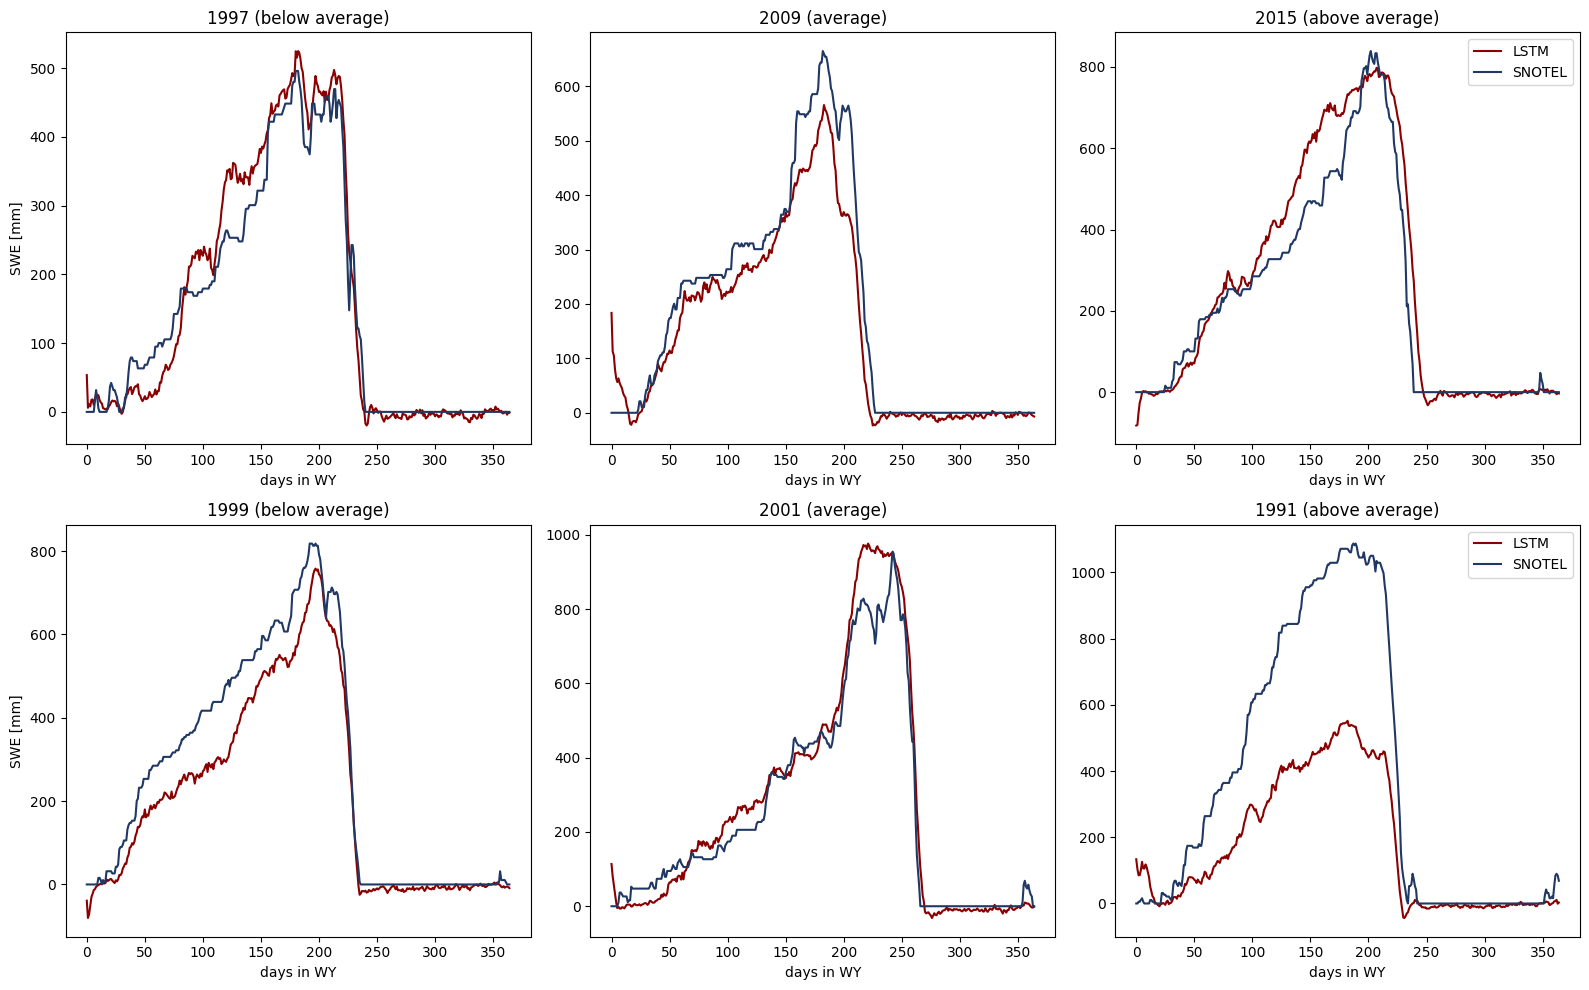

In [40]:
## TESTING DATA ##
# blue is actual, red is predicted
plt.figure(figsize=(16,10))
statistics = pd.DataFrame(columns=['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'delta days'])
for y in range(num_test_yrs):
    wy = testing_years[y]

    test_swe_tensors = torch.from_numpy(full_swe_2[y])
    test_non_swe_tensors = torch.from_numpy(full_non_swe_2[y])

    # predict 
    swe_pred = lstm(torch.reshape(test_non_swe_tensors, (test_non_swe_tensors.shape[0], 1, test_non_swe_tensors.shape[1])))

    # inverse transform to produce swe values
    swe_pred = scaler_swe.inverse_transform(swe_pred.detach().numpy().reshape(-1,1))
    swe_actual = scaler_swe.inverse_transform(test_swe_tensors.detach().numpy())

    # peak swe
    peak_lstm = max(swe_pred)[0]
    peak_obs = max(swe_actual)[0]
    peak = (peak_lstm + peak_obs)/2

    # calculate RMSE
    mse = mean_squared_error(swe_actual, swe_pred)
    rmse = np.sqrt(mse)

    # calculate NSE
    nash_sut = nse(swe_actual, swe_pred)

    # calculate r2
    r_2 = r2_score(swe_actual, swe_pred)

    # calculate Spearman's rho
    spearman_rho = stats.spearmanr(swe_actual, swe_pred)[0]

    # calculate delta peak SWE
    delta_peak = peak_lstm - peak_obs

    # calculate first snow free day
    # obs/clm: swe == 0
    # pred: swe < 0
    arr_lstm = np.where(swe_pred < 0)[0]
    arr_obs = np.where(swe_actual == 0)[0]
    melt_lstm = np.where(arr_lstm > 100)[0]
    melt_obs = np.where(arr_obs > 100)[0]
    try:
        delta_days = arr_lstm[melt_lstm[0]] - arr_obs[melt_obs[0]]
    except:
        delta_days = 365 - arr_obs[melt_obs[0]]

    statistics.loc[len(statistics)] = [rmse, rmse / peak, nash_sut, r_2, spearman_rho, delta_peak, delta_peak/peak, delta_days]

    #print(swe_pred)
    plt.subplot(2, 3, y+1)
    plt.plot(swe_pred, c='darkred', label='LSTM')
    plt.plot(swe_actual, c='#203864', label='SNOTEL')
    plt.title(f'{testing_years[y]:.0f} ') 
    plt.xlabel('days in WY')
    if (y%3) == 1:
        plt.title(f'{testing_years[y]:.0f} (average)') 
    if (y%3) == 2:
        plt.title(f'{testing_years[y]:.0f} (above average)')
        plt.legend()
    if (y%3) == 0:
        plt.title(f'{testing_years[y]:.0f} (below average)') 
        plt.ylabel('SWE [mm]')

    # save the output files
    swe_pred = pd.DataFrame(swe_pred)
    swe_actual = pd.DataFrame(swe_actual)
    #swe_pred.to_csv(os.path.join('single_column_slumgullion/', str(wy)+'_swe_pred.txt'),sep=' ',header=None, index=False, index_label=False)
    #swe_actual.to_csv(os.path.join('single_column_slumgullion/', str(wy)+'_swe_actual.txt'),sep=' ',header=None, index=False, index_label=False)
    
plt.tight_layout()

print(f"RMSE: {np.mean(statistics['rmse']):.2f}")
print(f"normal RMSE: {np.mean(statistics['normal rmse']):.2f}")
print(f"NSE: {np.mean(statistics['nse']):.2f}")
print(f"R2: {np.mean(statistics['r2']):.2f}")
print(f"Spearman's rho: {np.mean(statistics['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.mean(statistics['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.mean(statistics['normal delta peak']):.2f}")
print(f"delta days: {np.mean(statistics['delta days']):.2f}")

statistics.to_csv('single_column_slumgullion/sc_slumgullion_statistics.txt',sep=' ',header=None, index=False, index_label=False)